<a href="https://colab.research.google.com/github/fedhere/DSPS_FBianco/blob/master/HW1/CentralLimitTheorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Written by Federica B. Bianco @fedhere
UDel DSPS

 # Homework 2

 This is a skeleton & instruction notebook

-  GENERATE  100 samples of different sizes N (N>10 & N<2000) from each of 5 different distributions (500 samples in total), 
 _all with the same population mean_. Include a _Normal_, a _Poisson_, a _Binomial_, a _Chi-Squared_ distribution, and 1 more of your choice.                                       
-  For each sample plot the sample mean (dependent var.) against the sample size N (independent var.) (if you want you can do it with the sample standard deviation as well). 
-  Describe the behavior you see in the plots in terms of the law of large numbers.
-  PLOT the distributions of all sample means (together for all distributions). _Mandatory_: as a histogram. _Optional_: in any other way you think is convincing
-  Extra Credit (required for 661 students): FIT a gaussian to the distribution of means            

## Imports and Notebook Setup

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from numpy.random import default_rng
from scipy.optimize import curve_fit, minimize

# This package sets up pretty plots
import seaborn as sns

# Default print is boring, lets use LaTeX
from IPython.display import Latex
from IPython.display import display

sns.set_style("darkgrid")
sns.set()

def latexPrint(string):
    """
    Formats Strings using LaTeX

    :param string: Input Python String
    :return display: Output Display Object 
    """
    return(display(Latex(string)))

%load_ext pycodestyle_magic
%pycodestyle_on
%matplotlib inline

14:1: E402 module level import not at top of file
15:1: E402 module level import not at top of file
17:1: E302 expected 2 blank lines, found 1
22:43: W291 trailing whitespace


## Let's see what this distribution looks like, what is the PDF, and how are the moments defined. Wikipedia is great for this! 

In [5]:
%%html

<!-- From https://www.w3schools.com/howto/howto_css_images_side_by_side.asp -->
<style>
 /* Three image containers (use 25% for four, and 50% for two, etc) */
.column {
  float: left;
  width: 50%;
  padding: 5px;
}

/* Clear floats after image containers */
.row::after {
  content: "";
  clear: both;
  display: table;
} 
</style>
 <div class="row">
  <div class="column">
    <img src="https://raw.githubusercontent.com/fedhere/DSPS_2019/master/HW2/chisq1.png" alt="Snow" style="width:100%">
  </div>
  <div class="column">
    <img src="https://raw.githubusercontent.com/fedhere/DSPS_2019/master/HW2/chisq2.png" alt="Forest" style="width:100%">
  </div>
</div> 

## Helper Functions

In [6]:
# Lets make some functions to reduce boiler plate code
random_gen = default_rng(42069666)
dist_list = [x for x in dir(random_gen) if not x.startswith('_')]
dist_cache = {}

def random_dist(dist_name, dist_args=[], use_cached=False, **kwargs):
    """
    Dynamically creates distribution objects from the generator
    object, reduces the amount of boiler plate code

    
    :param dist_name: Input function name for distribution
    :param dist_args: Passed to distribution constructor
    :param use_cached: Every time a distribution is created, it is put into a cache. This tells the funciton to return the cached function
    :param kwargs: Passed to distribution constructor
    
    :return dist_obj: Output Distribution all built
    """
    if use_cached and dist_name in dist_cache:
        return dist_cache[dist_name]
    if dist_name in dist_list:
        dist_obj = getattr(random_gen, dist_name)(*dist_args, **kwargs)
        dist_cache[dist_name] = dist_obj
        return dist_obj
    raise AttributeError(f"Unknown Distribution {dist_name}, please select from possible list: {dist_list}")

axes_keywords = [
    "xlabel", "xlim", "xmargin", "xscale", 
    "xticklabels", "xticks", "ybound", 
    "ylabel", "ylim", "ymargin", "yscale", 
    "yticklabels", "yticks", "zorder", "title"
]

axes_override = ['xlabel', 'ylabel', 'title']


def plot_make(plot_args, plot_type, figure=None, **kwargs):
    """
    Builds Plots easily

    :param in_data: Input data for future plot
    :param plot_type: Which plot type is this function building
    :param kwargs: Passed to plot constructor
    
    :return plot_obj: Plot constructor return
    """
    
    # Parse kwargs
    axes_kwargs = {}
    plot_kwargs = {}
    
    for keyword, value in kwargs.items():
        if keyword in axes_keywords:
            axes_kwargs[keyword] = value
        else:
            plot_kwargs[keyword] = value
    
    # Check for inputted figure
    if figure is None:
        figure = plt.figure()
    
    # Utilize set_* functions
    axes_over_args = dict([(override, axes_kwargs.pop(override)) for override in axes_override if override in axes_kwargs])
    
    # Build Axes Object
    axis_obj = plt.axes(**axes_kwargs)
    
    # Parse override arguments
    for key, value in axes_over_args.items():
        set_args = []
        set_kwargs = {}
        if isinstance(value, list):
            for arg in value:
                if isinstance(arg, dict):
                    set_kwargs.update(arg)
                else:
                    set_args.append(arg)
        else:
            set_args.append(value)
        getattr(axis_obj, "set_" + key)(*set_args, **set_kwargs)
    
    # Put it all together to make a plot
    figure.add_axes(axis_obj)
    plt_return_values = getattr(axis_obj, plot_type)(*plot_args, **plot_kwargs)
    
    # Return all the relevant objects
    return (figure, axis_obj, plt_return_values)

6:1: E302 expected 2 blank lines, found 1
11:1: W293 blank line contains whitespace
14:80: E501 line too long (138 > 79 characters)
16:1: W293 blank line contains whitespace
25:80: E501 line too long (108 > 79 characters)
27:1: E305 expected 2 blank lines after class or function definition, found 1
28:43: W291 trailing whitespace
29:39: W291 trailing whitespace
30:43: W291 trailing whitespace
44:1: W293 blank line contains whitespace
47:1: W293 blank line contains whitespace
51:1: W293 blank line contains whitespace
57:1: W293 blank line contains whitespace
61:1: W293 blank line contains whitespace
63:80: E501 line too long (123 > 79 characters)
64:1: W293 blank line contains whitespace
67:1: W293 blank line contains whitespace
81:1: W293 blank line contains whitespace
85:1: W293 blank line contains whitespace


## Let's examine several distributions
### Chi-Square
#### Give the distribution a *population* mean

In [7]:
dist_mean = 100

#### For chi-square distributions, the degrees of freedom is the same as mean

In [8]:
chi_sq_df = dist_mean

#### Make the plot

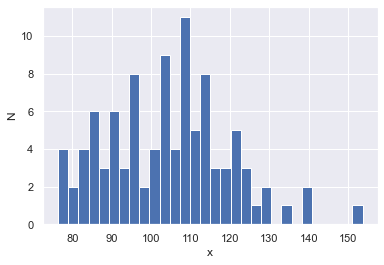

1:74: E251 unexpected spaces around keyword / parameter equals
1:76: E251 unexpected spaces around keyword / parameter equals
1:80: E501 line too long (104 > 79 characters)
1:104: E703 statement ends with a semicolon


In [9]:
plot_make([random_dist('chisquare', [chi_sq_df], size=100)], 'hist', bins = 30, ylabel='N', xlabel='x');

#### Figure 1: Chi sq distribution of a sample of size 100 for a Chi square distribution with  100 degrees of freedom. 

#### let numpy calculate what the mean and stdev of this distribution are

In [10]:
latexPrint(
    f"Chi-Square mean: {np.around(random_dist('chisquare', use_cached=True).mean(), 2)}, "
    f"Standard Deviation: {np.around(random_dist('chisquare', use_cached=True).std(), 2)}"
)

<IPython.core.display.Latex object>

2:80: E501 line too long (90 > 79 characters)
3:80: E501 line too long (90 > 79 characters)


### Analysis of variable sized samples from Chi-Square Distributions
we want distributions of different sizes (all integers between 10 and 2000). It's a good idea to create more small distributions, cause, as we will see, their means will be more noisy (due to the law of large numbers which we discussed in class). Here are some tricks to create the distribution sizes 

In [11]:
chi_sq_size_list = (2000 / (np.array(range(1, 100, 2)))).astype(int)
latexPrint(
    f"shape of the 'size' list that "
    f"contains the size of each distribution : {chi_sq_size_list.shape[0]}"
)

plot_make([chi_sq_size_list, '.'], 'plot', xlabel='index', ylabel='size of the distributions to be created');

chi_sq_mean_list = np.zeros(len(chi_sq_size_list))

for chi_sq_index, chi_sq_size in enumerate(chi_sq_size_list):
    chi_sq_test = random_dist('chisquare', [Chi Squared], size=chi_sq_size)
    chi_sq_mean_list[chi_sq_index] = np.mean(chi_sq_test)


new_fig = plt.figure(figsize=(10,6))


fig, ax, rv = plot_make(
    [chi_sq_size_list, chi_sq_mean_list], 
    'scatter',
    figure=new_fig,
    ylabel=['Sample Mean', {'fontsize': 18}],
    xlabel=['Size of Sample', {'fontsize': 18}],
    title=[f'Scatter Plot of Sample Means from a Chi Squared Distribution with parameter: {Chi Squared}\n Each Sample is Differently Size', {'fontsize': 18}]
)

ax.tick_params(labelsize=15)
ax.plot([min(chi_sq_size_list), max(chi_sq_size_list)], [chi_sq_df, chi_sq_df], 'k')
ax.text(ax.get_xlim()[1] * .6, 100, "expected mean", va="bottom", fontsize=20);

<IPython.core.display.Latex object>

#### Figure 2: As the number of samples from the distribution grows, the mean of the sample converges on the mean of the distribution.

## Now the histogram of the mean of all samples

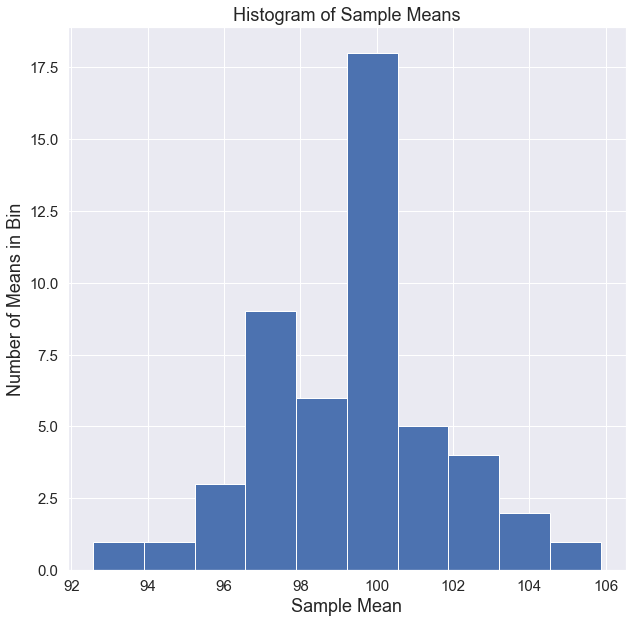

4:24: W291 trailing whitespace


In [14]:
fig = plt.figure(figsize=(10, 10))

fig, ax, rv = plot_make(
    [chi_sq_mean_list], 
    'hist',
    bins=10,
    figure=fig,
    xlabel=['Sample Mean', {'fontsize': 18}],
    ylabel=['Number of Means in Bin', {'fontsize': 18}],
    title=['Histogram of Sample Means', {'fontsize': 18}]
)

ax.tick_params(labelsize=15)

#### Figure 3: The distribution of sample means are distributed around the population mean, 100, with a slight spread ranging from 93 to 105

In [15]:
# Helper Function to build the distribution plots

def make_info(dist_name, dist_print_name, dist_args=[]):
    dist_size_list = (2000 / (np.array(range(1, 100, 2)))).astype(int)
    dist_mean_list = np.zeros(len(dist_size_list))
    
    for index, size in enumerate(dist_size_list):
        test_sample = random_dist(dist_name, dist_args, size=size)
        dist_mean_list[index] = np.mean(test_sample)
    
    fig = plt.figure(figsize=(10, 10))
    fig, ax, rv = plot_make(
        [dist_mean_list], 
        'hist',
        bins=6,
        figure=fig,
        xlabel=['Sample Mean', {'fontsize': 18}],
        ylabel=['Number of Means in Bin', {'fontsize': 18}],
        title=[f'Histogram of Sample Means for \nthe {dist_print_name} Distribution with Variable Sample Sizes', {'fontsize': 18}]
    )

    ax.tick_params(labelsize=15)
    
    return (fig, ax, rv)

dist_rv_cache = []

6:1: W293 blank line contains whitespace
10:1: W293 blank line contains whitespace
13:26: W291 trailing whitespace
19:80: E501 line too long (130 > 79 characters)
23:1: W293 blank line contains whitespace
26:1: E305 expected 2 blank lines after class or function definition, found 1


### Do it for the Normal distribution


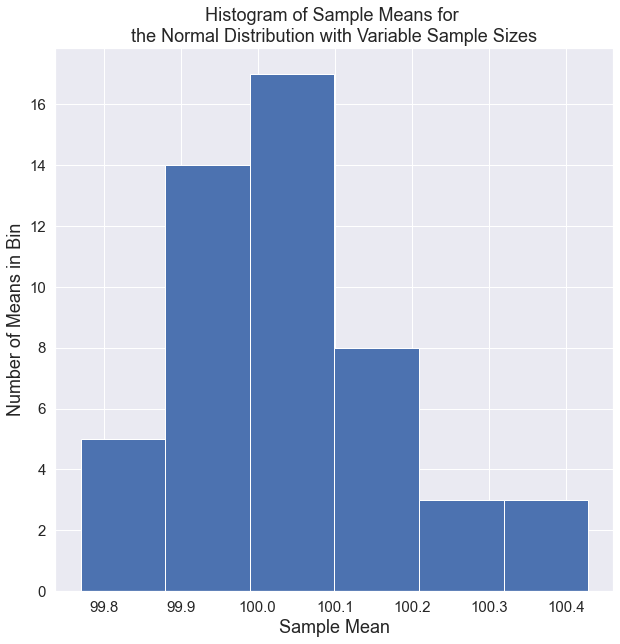

In [16]:
rv = make_info("normal", "Normal", [100])
dist_rv_cache.append(list(rv))

### Do it for the Poisson distribution

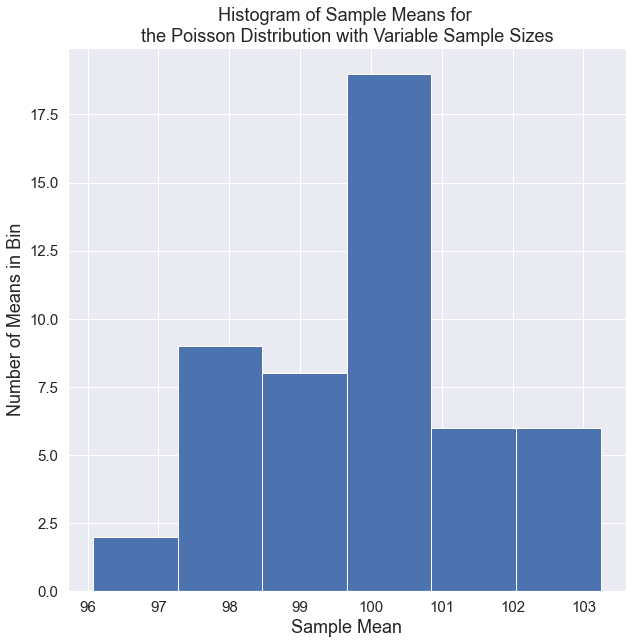

In [17]:
rv = make_info("poisson", "Poisson", [100])
dist_rv_cache.append(list(rv))

### Do it for the Binomial distribution

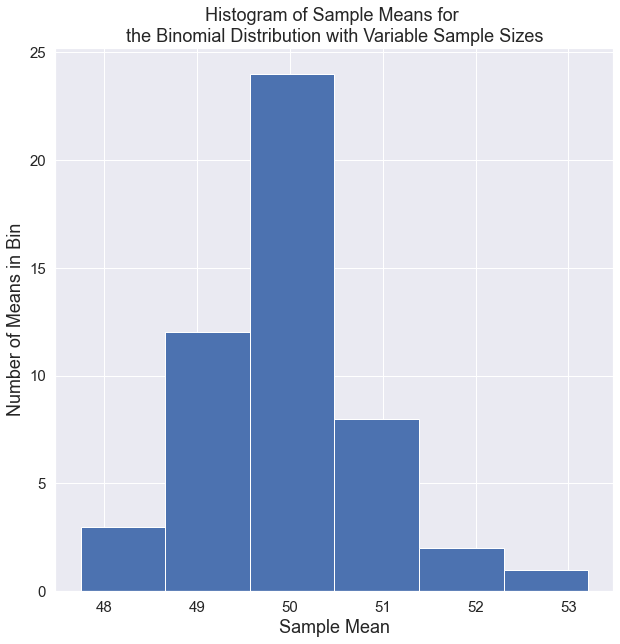

In [18]:
rv = make_info("binomial", "Binomial", [100, 0.5])
dist_rv_cache.append(list(rv))

### Do it for another distribution

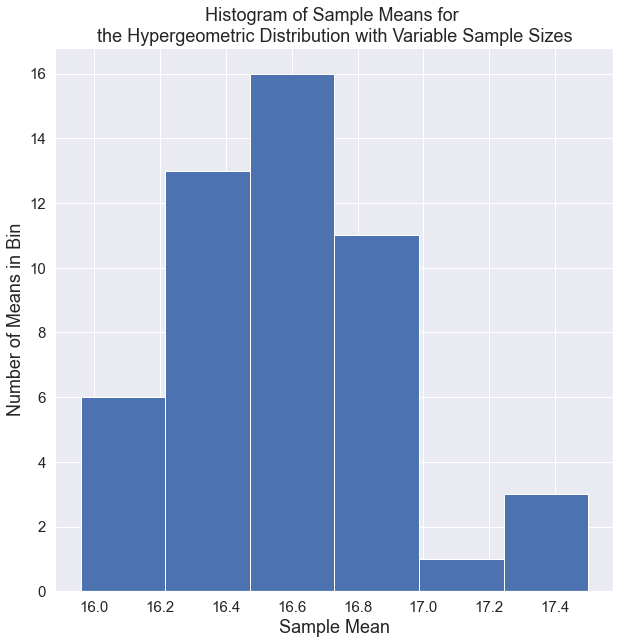

In [19]:
rv = make_info("hypergeometric", "Hypergeometric", [100, 50, 25])
dist_rv_cache.append(list(rv))

### Fitting a Gaussian to the histograms of the means for each distribution

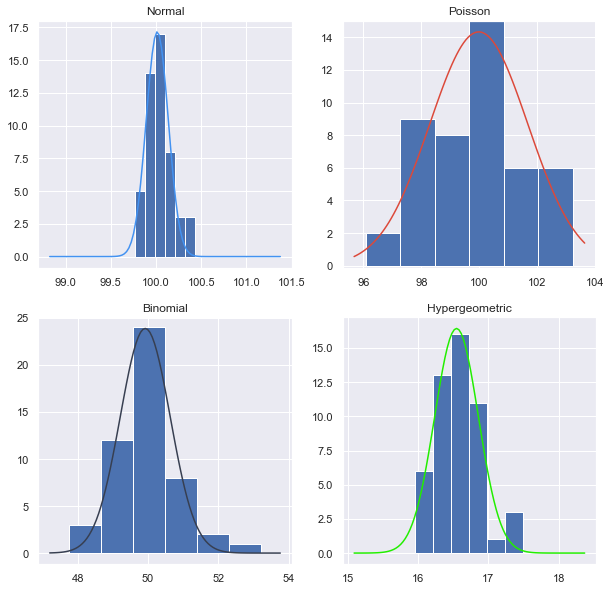

2:80: E501 line too long (103 > 79 characters)
4:1: E302 expected 2 blank lines, found 1
6:80: E501 line too long (89 > 79 characters)
20:1: W293 blank line contains whitespace
21:80: E501 line too long (80 > 79 characters)


In [24]:
def convert_to_x(in_bin_arr):
    return [in_bin_arr[i] + abs(in_bin_arr[i] - in_bin_arr[i+1])/2 for i in range(len(in_bin_arr) - 1)]

def gaus_fn(x, height, std_dev, mean):
    x = np.array(x)
    return height * 0.3989422804 * 1/std_dev * np.exp(np.square((x - mean)/std_dev) / -2)


fig = plt.figure(figsize=(10, 10))

plt_colors = ['#4392F1', '#DC493A', '#373F51', '#22EE00']
plt_titles = ['Normal', 'Poisson', 'Binomial', 'Hypergeometric']

ax_index = 1
for old_fig, old_ax, dist_rv in dist_rv_cache:
    ys = list(dist_rv[0])
    xs = convert_to_x(dist_rv[1])

    inital_guess = (100.0, 1000.0, 1000.0)
    
    params, covar = curve_fit(gaus_fn, xs, ys, method='dogbox', p0=inital_guess)

    in_xs = np.linspace(min(xs) - 1.0, max(xs) + 1.0, 100)
    fitted_ys = gaus_fn(in_xs, *params)

    new_ax = fig.add_subplot(2, 2, ax_index)
    new_ax.plot(in_xs, fitted_ys, color=plt_colors[ax_index - 1])
    for bar in dist_rv[2]:

        cen = bar.get_xy()
        wid = bar.get_width()
        hei = bar.get_height()

        new_ax.add_artist(mpl.patches.Rectangle(cen, wid, hei))

    new_ax.set_title(plt_titles[ax_index - 1])
    ax_index += 1

plt.show()